# Predicting the Surface Area of Metal-Organic Frameworks
### By: Jay Siri, jaysiri@mit.edu

This notebook contains the code used to predict and analyze the surface area of metal-organic frameworks from the MOFXDB dataset with the following methods:
1. BET Theory Estimation
2. Machine Learning Models
3. Physics-Informed Machine Learning Models

## 0. Set Up and Data

In [274]:
# Install necessary packages
!python3 -m pip install mofdb_client
!python3 -m pip install xgboost

In [326]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import xgboost as xgb

from collections import defaultdict
from mofdb_client import fetch
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [111]:
# Constants
N_a = 6.022 * 10**23 # Avogadro's number, mols^-1
A_m = 0.162 * 10**-18 # m^2
M_v = 22414 #cm^3/mol

In [280]:
# Load dataset into df
NUM_MOFS = 1000
coremof_2019_list = [mof for mof in fetch(loading_unit="cm3(STP)/g", pressure_unit="atm", database="CoREMOF 2019", limit=NUM_MOFS)]
coremof_2019_df = pd.DataFrame(coremof_2019_list)
coremof_2019_df.head()

,id,name,cif,isotherms,heats,void_fraction,surface_area_m2g,surface_area_m2cm3,pld,lcd,pxrd,pore_size_distribution,database,url,adsorbates,elements,mofid,mofkey,batch_number,json_repr
0,173866,ABAVIJ_clean,data_ABAVIJ_clean\(2)\n_audit_creation_date ...,"[{'id': 7120195, 'isotherm_data': [{'pressure'...",[],0.3792,204.633,312.052,2.49720,4.45543,None,None,CoREMOF 2019,/mofs/173866.json,"[{'id': 80, 'InChIKey': 'IJGRMHOSHXDMSA-UHFFFA...",[],None,None,41,"{'id': 173866, 'mofid': None, 'mofkey': None, ..."
1,173867,ABAYIO_clean,data_image0\n_cell_length_a 26.771\n_cel...,"[{'id': 7120196, 'isotherm_data': [{'pressure'...",[],0.6636,1936.750,1838.220,4.32260,11.39490,None,None,CoREMOF 2019,/mofs/173867.json,"[{'id': 80, 'InChIKey': 'IJGRMHOSHXDMSA-UHFFFA...",[],None,None,41,"{'id': 173867, 'mofid': None, 'mofkey': None, ..."
2,173868,ABAYOU_clean,data_image0\n_cell_length_a 26.647\n_cel...,"[{'id': 7120197, 'isotherm_data': [{'pressure'...",[],0.6638,1922.330,1882.480,4.51080,11.27340,None,None,CoREMOF 2019,/mofs/173868.json,"[{'id': 80, 'InChIKey': 'IJGRMHOSHXDMSA-UHFFFA...",[],None,None,41,"{'id': 173868, 'mofid': None, 'mofkey': None, ..."
3,173869,ABEFUL_clean,data_image0\n_cell_length_a 15.3873\n_ce...,"[{'id': 7120198, 'isotherm_data': [{'pressure'...",[],0.4118,269.806,418.490,3.32948,4.93969,None,None,CoREMOF 2019,/mofs/173869.json,"[{'id': 80, 'InChIKey': 'IJGRMHOSHXDMSA-UHFFFA...",[],None,None,41,"{'id': 173869, 'mofid': None, 'mofkey': None, ..."
4,173870,ABESUX_clean,data_image0\n_cell_length_a 15.512\n_cel...,"[{'id': 7120199, 'isotherm_data': [{'pressure'...",[],0.5646,466.934,1747.690,4.42492,5.87931,None,None,CoREMOF 2019,/mofs/173870.json,"[{'id': 80, 'InChIKey': 'IJGRMHOSHXDMSA-UHFFFA...",[],None,None,41,"{'id': 173870, 'mofid': None, 'mofkey': None, ..."


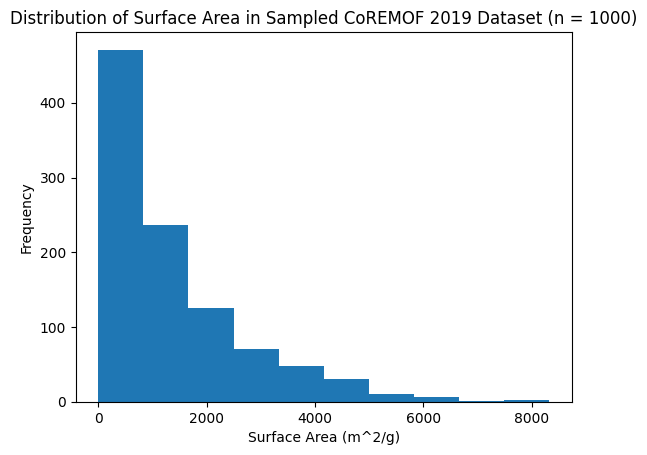

In [281]:
# Visualize dataset surface area distribution
plt.hist(coremof_2019_df["surface_area_m2g"])
plt.xlabel("Surface Area (m^2/g)")
plt.ylabel("Frequency")
plt.title(f"Distribution of Surface Area in Sampled CoREMOF 2019 Dataset (n = {NUM_MOFS})")
plt.show()

In [282]:
true_sa = {} # {id : true surface area}

for mof in coremof_2019_list:
  true_sa[mof.id] = mof.surface_area_m2g

print(true_sa)

{173866: 204.633, 173867: 1936.75, 173868: 1922.33, 173869: 269.806, 173870: 466.934, 173871: 492.461, 173872: 3810.89, 173873: 552.208, 173874: 2463.35, 173875: 540.302, 173876: 528.037, 173877: 493.66, 173878: 482.256, 173879: 465.792, 173880: 448.697, 173881: 418.836, 173882: 898.121, 173883: 1506.68, 173884: 1089.26, 173885: 752.116, 173886: 753.879, 173887: 920.046, 173888: 376.88, 173889: 144.762, 173890: 8.15274, 173891: 525.866, 173892: 1873.86, 173893: 4393.52, 173894: 4382.42, 173895: 4461.21, 173896: 1505.09, 173897: 293.64, 173898: 1240.99, 173899: 1138.35, 173900: 22.6416, 173901: 1015.2, 173902: 2579.3, 173903: 1273.96, 173904: 1812.15, 173905: 2492.34, 173906: 2315.35, 173907: 2527.25, 173908: 1318.96, 173909: 673.218, 173910: 1139.36, 173911: 2631.69, 173912: 1099.29, 173913: 365.232, 173914: 2743.3, 173915: 988.368, 173916: 780.315, 173917: 4935.34, 173918: 684.446, 173919: 2076.59, 173920: 1441.52, 173921: 2730.07, 173922: 1105.59, 173923: 2402.71, 173924: 304.239, 17

## 1. BET Theory Estimation

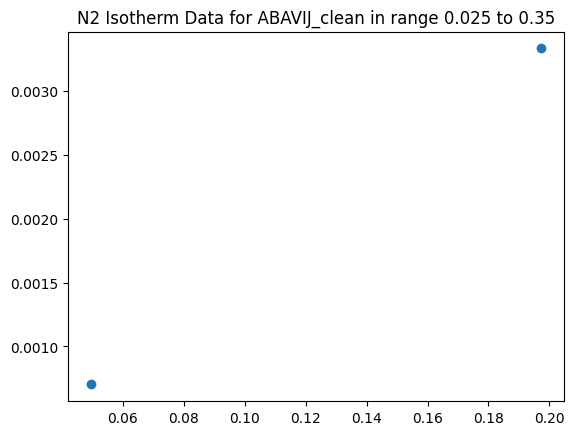

Raw Isotherm Data: Isotherm(id=7120195, isotherm_data=[TemperaturePoint(pressure=0.5921539600296077, species_data=[GasAtTemp(InChIKey='IJGRMHOSHXDMSA-UHFFFAOYSA-N', name='Nitrogen', composition=1.0, adsorption=73.9402)]), TemperaturePoint(pressure=0.004934616333580064, species_data=[GasAtTemp(InChIKey='IJGRMHOSHXDMSA-UHFFFAOYSA-N', name='Nitrogen', composition=1.0, adsorption=71.4569)]), TemperaturePoint(pressure=0.7895386133728103, species_data=[GasAtTemp(InChIKey='IJGRMHOSHXDMSA-UHFFFAOYSA-N', name='Nitrogen', composition=1.0, adsorption=73.9402)]), TemperaturePoint(pressure=0.019738465334320256, species_data=[GasAtTemp(InChIKey='IJGRMHOSHXDMSA-UHFFFAOYSA-N', name='Nitrogen', composition=1.0, adsorption=73.9402)]), TemperaturePoint(pressure=0.0007895386133728103, species_data=[GasAtTemp(InChIKey='IJGRMHOSHXDMSA-UHFFFAOYSA-N', name='Nitrogen', composition=1.0, adsorption=57.429899999999996)]), TemperaturePoint(pressure=0.39476930668640514, species_data=[GasAtTemp(InChIKey='IJGRMHOSHXD

/tmp/ipython-input-2580899809.py:27: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)




BET Surface Area Estimates: {173866: np.float64(247.39810470964107), 173867: np.float64(1132.2758004866564), 173868: np.float64(1114.5540418174116), 173869: np.float64(239.7552186323971), 173870: np.float64(286.0595739149905), 173871: np.float64(277.9299670972246), 173872: np.float64(2482.162568594082), 173873: np.float64(363.6577936273912), 173875: np.float64(360.1091451116858), 173876: np.float64(340.69915632989455), 173877: np.float64(333.77176369871694), 173878: np.float64(318.43685974958413), 173879: np.float64(314.17288746634665), 173880: np.float64(309.2204637621276), 173881: np.float64(243.06884412731767), 173882: np.float64(629.8560238595102), 173883: np.float64(778.1624480505598), 173884: np.float64(739.1350486729789), 173885: np.float64(496.225452753451), 173886: np.float64(526.0896624824868), 173887: np.float64(536.4316350663338), 173888: np.float64(352.45888956884073), 173889: np.float64(334.01364050381517), 173890: np.float64(71.25352390915211), 173891: np.float64(335.1

In [284]:
BET_sa_estimates = {} # {id : BET surface area}
example_plotted = False

P_0 = 1 # atm
LOWEST_RELATIVE_PRESSURE = 0.025
HIGHEST_RELATIVE_PRESSURE = 0.35

for mof in coremof_2019_list:
  isotherms = mof.isotherms

  # Extract relevant data (pressure, adsorption) from N2 isotherm
  for isotherm in isotherms:
    n2_pressure_and_adsorption = []
    for datapoint in isotherm.isotherm_data:
      if datapoint.species_data[0].name == "Nitrogen":
        if LOWEST_RELATIVE_PRESSURE <= datapoint.pressure <= HIGHEST_RELATIVE_PRESSURE:
          n2_pressure_and_adsorption.append((datapoint.pressure, datapoint.species_data[0].adsorption))

    # Calculate monolayer capacity as 1 / (slope + intercept) from OLS
    if n2_pressure_and_adsorption:

      # X is P / P0
      x = [(datapoint[0] / P_0) for datapoint in n2_pressure_and_adsorption]
      # Y is P / (adsorption * (P - P0))
      y = [(datapoint[0] / ((datapoint[1] + 10**-10) * (P_0 - datapoint[0]))) for datapoint in n2_pressure_and_adsorption]

      slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
      X_m = 1 / (slope + intercept)

      # Calculate SA, units: (cm^3 /g) * (mol^-1) * (m^2) / (cm^3/mol) = m^2 / g
      bet_surface_area = X_m * N_a * A_m / M_v
      BET_sa_estimates[mof.id] = bet_surface_area

      # Print out one example for visualization
      if not example_plotted:
        plt.scatter(x, y)
        plt.title(f"N2 Isotherm Data for {mof.name} in range {LOWEST_RELATIVE_PRESSURE} to {HIGHEST_RELATIVE_PRESSURE}")
        plt.show()
        print(f"Raw Isotherm Data: {isotherm}")
        print(f"Slope: {slope}")
        print(f"Intercept: {intercept}")
        print(f"Monolayer Capacity (cm3(STP)/g): {X_m}")
        print(f"BET Surface Area (m2/g): {bet_surface_area}")
        print(f"True Surface Area (m2/g): {mof.surface_area_m2g}")
        example_plotted = True

print(f"\n\nBET Surface Area Estimates: {BET_sa_estimates}")


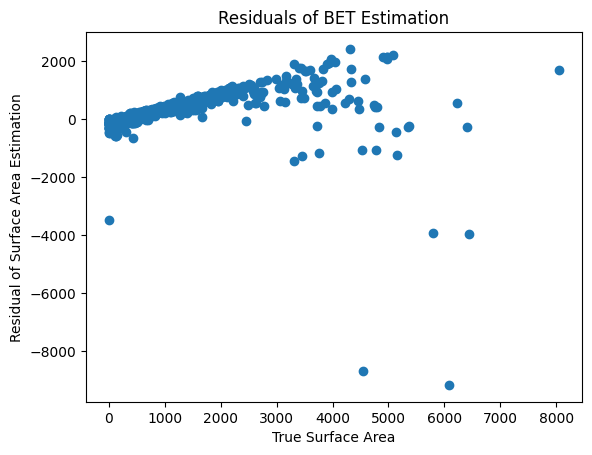

In [319]:
sa_values = []
for id in BET_sa_estimates.keys():
  if not np.isnan(BET_sa_estimates[id]):
    sa_values.append(true_sa[id])

BET_sa_estimates_filtered = [v for v in BET_sa_estimates.values() if not np.isnan(v)]

plt.scatter(sa_values, np.array(sa_values) - np.array(BET_sa_estimates_filtered))
plt.title("Residuals of BET Estimation")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

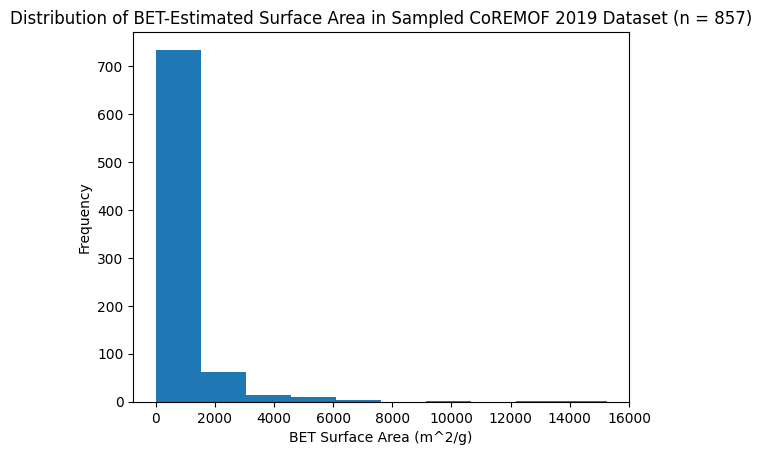

In [285]:
# Visualize BET surface area distribution
plt.hist(BET_sa_estimates.values())
plt.xlabel("BET Surface Area (m^2/g)")
plt.ylabel("Frequency")
plt.title(f"Distribution of BET-Estimated Surface Area in Sampled CoREMOF 2019 Dataset (n = {len(BET_sa_estimates)})")
plt.show()

In [364]:
print(f"R-squared Score: {r2_score(sa_values, BET_sa_estimates_filtered)}")
print(f"Mean Squared Error: {mean_squared_error(sa_values, BET_sa_estimates_filtered)}")
print(f"Mean Absolute Error: {mean_absolute_error(sa_values, BET_sa_estimates_filtered)}")
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(sa_values, BET_sa_estimates_filtered)}")

R-squared Score: 0.6162275306892804
Mean Squared Error: 542267.1678078526
Mean Absolute Error: 409.6797098270826
Mean Absolute Percentage Error: 3.3355540842616292e+16


## 2. Machine Learning Models

### Prepare ML Datasets

In [412]:
datapoints_dict = defaultdict(list)
isotherm_type_map = {}

for mof in coremof_2019_list:
  isotherms = mof.isotherms

  species_num = 0
  for isotherm in isotherms:
    for datapoint in isotherm.isotherm_data:
      datapoints_dict["id"].append(mof.id)

      if datapoint.species_data[0].name not in isotherm_type_map:
        isotherm_type_map[datapoint.species_data[0].name] = species_num
        species_num += 1

      datapoints_dict["isotherm_species_name"].append(isotherm_type_map[datapoint.species_data[0].name])
      datapoints_dict["isotherm_pressure"].append(datapoint.pressure)
      datapoints_dict["isotherm_adsorption"].append(datapoint.species_data[0].adsorption)

df = pd.DataFrame(datapoints_dict)
df.head()

,id,isotherm_species_name,isotherm_pressure,isotherm_adsorption
0,173866,0,0.592154,73.9402
1,173866,0,0.004935,71.4569
2,173866,0,0.789539,73.9402
3,173866,0,0.019738,73.9402
4,173866,0,0.000790,57.4299


In [413]:
def prepare_split_data(datasets):
  X, y = [], []
  max_len_to_pad_to = max([len(df[df["id"] == id]) for id in datasets])

  for id in datasets:
    y.append(true_sa[id])

    df_id = df[df["id"] == id]
    df_id = df_id.drop("id", axis=1)
    df_id_datapoints_list = df_id.values.tolist()

    # Pad datapoints up to the max number of datapoints using the mean
    if len(df_id_datapoints_list) < max_len_to_pad_to:
      species = [item[0] for item in df_id_datapoints_list]
      pressures = [item[1] for item in df_id_datapoints_list]
      adsorptions = [item[2] for item in df_id_datapoints_list]

      df_id_datapoints_list += [[statistics.mean(species), statistics.mean(pressures), statistics.mean(adsorptions)] for _ in range(max_len_to_pad_to - len(df_id_datapoints_list))]

    flattened_list = [item for sublist in df_id_datapoints_list for item in sublist]
    X.append(flattened_list)

  X = np.array(X)
  y = np.array(y)
  print(X.shape)
  print(y.shape)

  return X, y


In [414]:
train, test = train_test_split(coremof_2019_df["id"], test_size=0.2)
X_train, y_train = prepare_split_data(train)
X_test, y_test = prepare_split_data(test)

(800, 126)
(800,)
(200, 126)
(200,)


### Linear Regression

In [415]:
linear_regression_model = LinearRegression().fit(X_train, y_train)
y_pred_train_linreg = linear_regression_model.predict(X_train)
y_pred_linreg = linear_regression_model.predict(X_test)

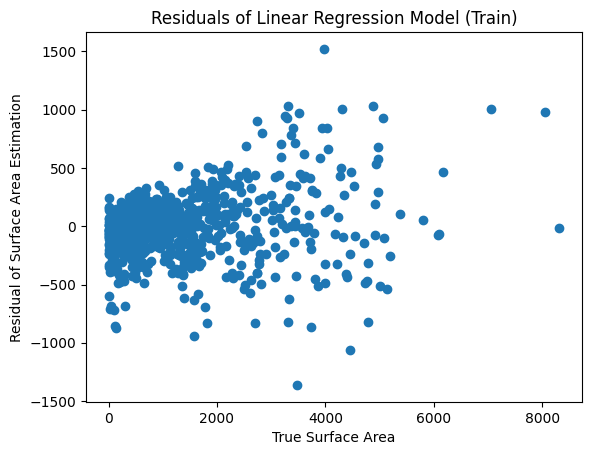

In [416]:
plt.scatter(y_train, y_train - y_pred_train_linreg)
plt.title("Residuals of Linear Regression Model (Train)")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

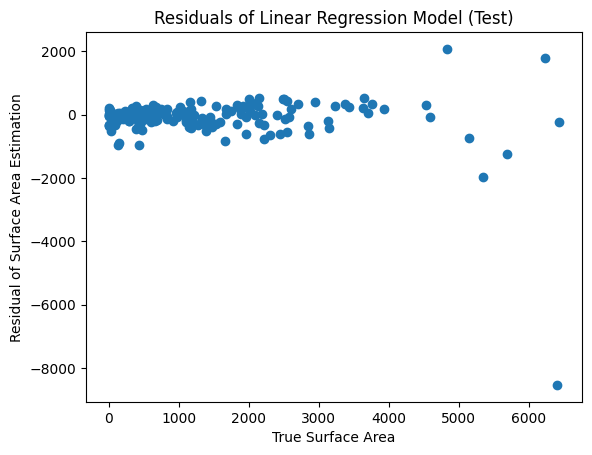

In [417]:
plt.scatter(y_test, y_test - y_pred_linreg)
plt.title("Residuals of Linear Regression Model (Test)")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

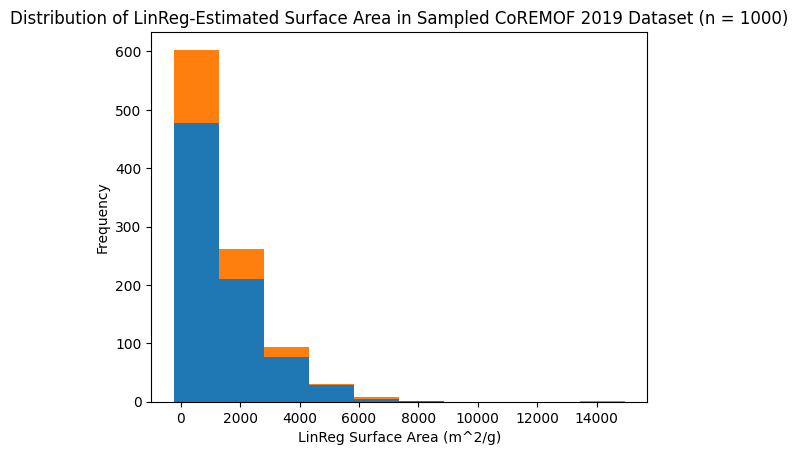

In [418]:
plt.hist((y_pred_train_linreg, y_pred_linreg), stacked=True)
plt.xlabel("LinReg Surface Area (m^2/g)")
plt.ylabel("Frequency")
plt.title(f"Distribution of LinReg-Estimated Surface Area in Sampled CoREMOF 2019 Dataset (n = {len(y_pred_train_linreg) + len(y_pred_linreg)})")
plt.show()

In [419]:
print(f"R-squared Score: {r2_score(y_test, y_pred_linreg)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_linreg)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_linreg)}")

y_test_mape = [1 if value <= 1 else value for value in y_test]
y_pred_linreg_mape = [1 if value <= 1 else value for value in y_pred_linreg]
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test_mape, y_pred_linreg_mape)}")

R-squared Score: 0.7069203639485362
Mean Squared Error: 507426.06076883903
Mean Absolute Error: 280.6672360107913
Mean Absolute Percentage Error: 3.053221210685157


### LASSO

In [420]:
lasso_model = Lasso(alpha=0.1).fit(X_train, y_train)
y_pred_train_lasso = lasso_model.predict(X_train)
y_pred_lasso = lasso_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e+07, tolerance: 1.384e+05
  model = cd_fast.enet_coordinate_descent(


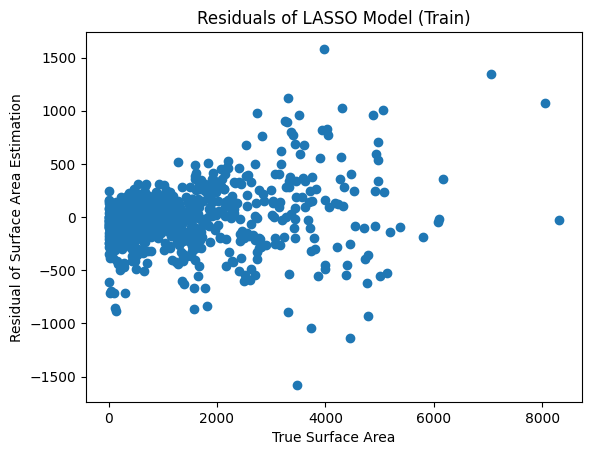

In [421]:
plt.scatter(y_train, y_train - y_pred_train_lasso)
plt.title("Residuals of LASSO Model (Train)")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

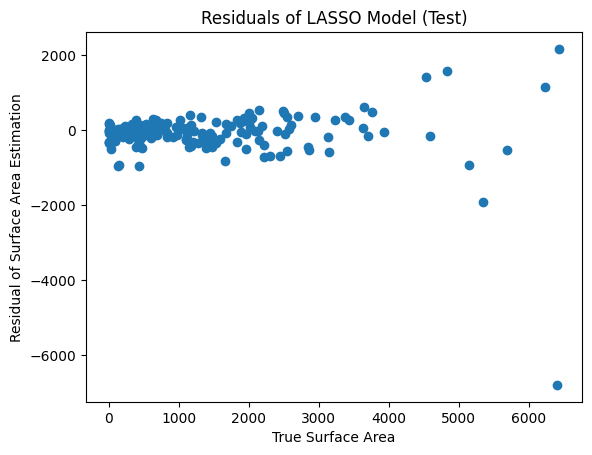

In [422]:
plt.scatter(y_test, y_test - y_pred_lasso)
plt.title("Residuals of LASSO Model (Test)")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

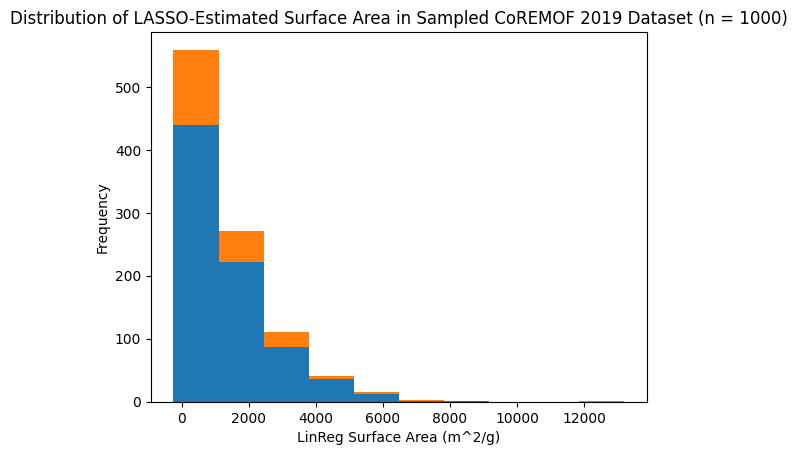

In [423]:
plt.hist((y_pred_train_lasso, y_pred_lasso), stacked=True)
plt.xlabel("LinReg Surface Area (m^2/g)")
plt.ylabel("Frequency")
plt.title(f"Distribution of LASSO-Estimated Surface Area in Sampled CoREMOF 2019 Dataset (n = {len(y_pred_train_lasso) + len(y_pred_lasso)})")
plt.show()

In [424]:
print(f"R-squared Score: {r2_score(y_test, y_pred_lasso)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_lasso)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_lasso)}")

y_pred_lasso_mape = [1 if value <= 1 else value for value in y_pred_lasso]
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test_mape, y_pred_lasso_mape)}")

R-squared Score: 0.7790297178225642
Mean Squared Error: 382578.88314214395
Mean Absolute Error: 278.0720756498663
Mean Absolute Percentage Error: 3.0609837283594943


### XGBoost

In [425]:
xgb_regression_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_regression_model.fit(X_train, y_train)
y_pred_train_xgb = xgb_regression_model.predict(X_train)
y_pred_xgb = xgb_regression_model.predict(X_test)

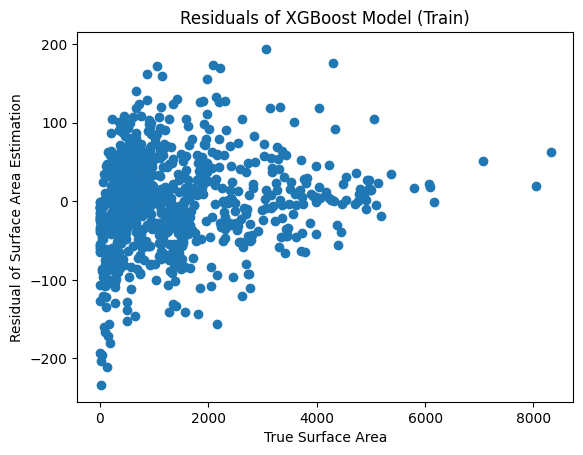

In [426]:
plt.scatter(y_train, y_train - y_pred_train_xgb)
plt.title("Residuals of XGBoost Model (Train)")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

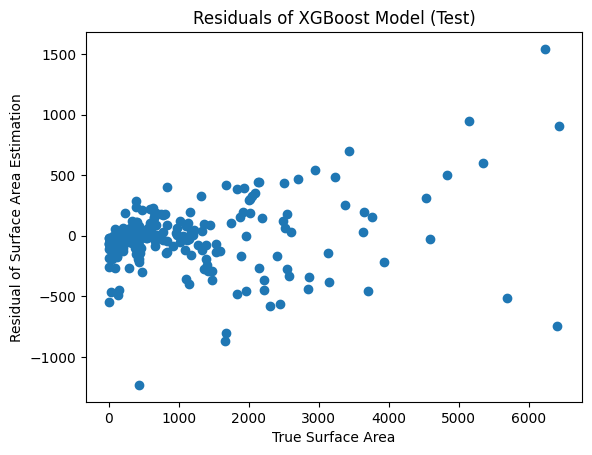

In [427]:
plt.scatter(y_test, y_test - y_pred_xgb)
plt.title("Residuals of XGBoost Model (Test)")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

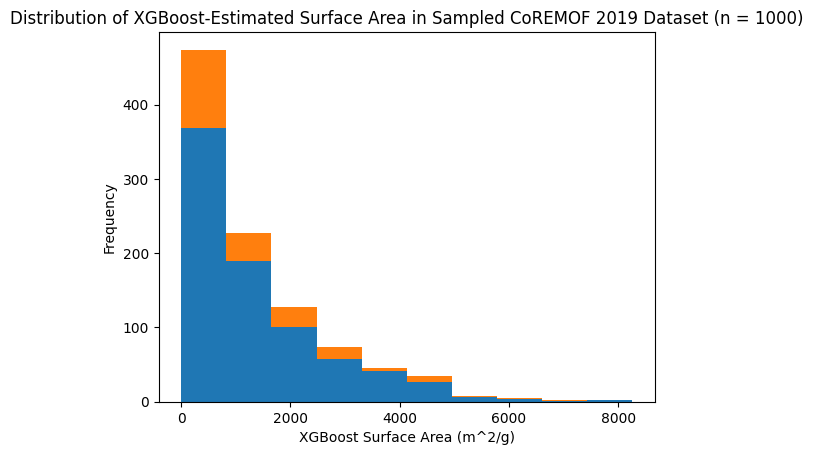

In [428]:
plt.hist((y_pred_train_xgb, y_pred_xgb), stacked=True)
plt.xlabel("XGBoost Surface Area (m^2/g)")
plt.ylabel("Frequency")
plt.title(f"Distribution of XGBoost-Estimated Surface Area in Sampled CoREMOF 2019 Dataset (n = {len(y_pred_train_xgb) + len(y_pred_xgb)})")
plt.show()

In [429]:
print(f"R-squared Score: {r2_score(y_test, y_pred_xgb)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_xgb)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_xgb)}")

y_pred_xgb_mape = [1 if value <= 1 else value for value in y_pred_xgb]
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test_mape, y_pred_xgb_mape)}")

R-squared Score: 0.948678034460539
Mean Squared Error: 88856.74608941398
Mean Absolute Error: 198.8984847585007
Mean Absolute Percentage Error: 4.960714688280393


### Deep Learning

In [430]:
mlp_regression_model = MLPRegressor(solver='lbfgs', hidden_layer_sizes=(15, 4), random_state=1)
mlp_regression_model.fit(X_train, y_train)
y_pred_train_mlp = mlp_regression_model.predict(X_train)
y_pred_mlp = mlp_regression_model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


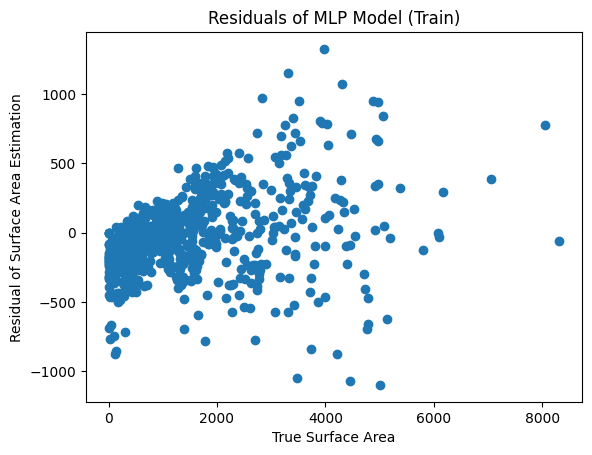

In [431]:
plt.scatter(y_train, y_train - y_pred_train_mlp)
plt.title("Residuals of MLP Model (Train)")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

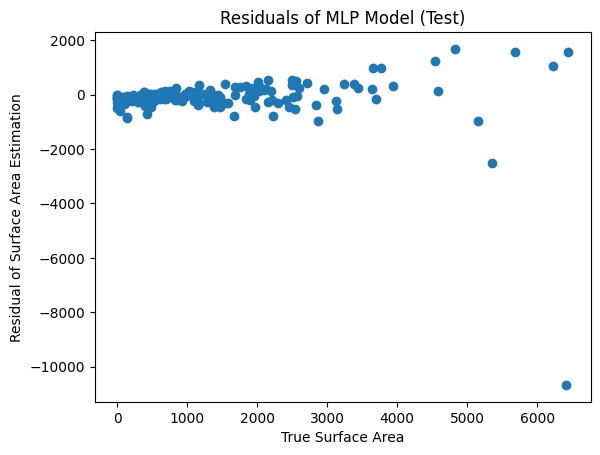

In [432]:
plt.scatter(y_test, y_test - y_pred_mlp)
plt.title("Residuals of MLP Model (Test)")
plt.xlabel("True Surface Area")
plt.ylabel("Residual of Surface Area Estimation")
plt.show()

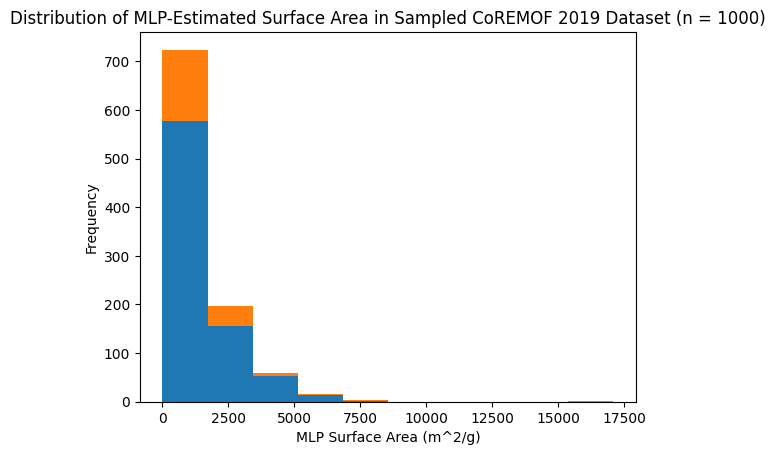

In [433]:
plt.hist((y_pred_train_mlp, y_pred_mlp), stacked=True)
plt.xlabel("MLP Surface Area (m^2/g)")
plt.ylabel("Frequency")
plt.title(f"Distribution of MLP-Estimated Surface Area in Sampled CoREMOF 2019 Dataset (n = {len(y_pred_train_mlp) + len(y_pred_mlp)})")
plt.show()

In [434]:
print(f"R-squared Score: {r2_score(y_test, y_pred_mlp)}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_mlp)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_mlp)}")

y_pred_mlp_mape = [1 if value <= 1 else value for value in y_pred_mlp]
print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test_mape, y_pred_mlp_mape)}")

R-squared Score: 0.5742958634995945
Mean Squared Error: 737046.6810579419
Mean Absolute Error: 309.80988837644844
Mean Absolute Percentage Error: 6.544800384774469
